In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import gmsh
from dolfinx import fem
import pandas as pd
import numpy as np

from mesh_and_materials.mesh import *
from mesh_and_materials.materials import *
from space.space_and_forms import *
from dirichlet_bc.bc import *

In [8]:
# load experimental data

df = pd.read_csv("experimental_data/geballe_2020_fig3_left_approx.csv")

df = df.copy()
df = df.iloc[1:].reset_index(drop=True)

df_pside = df[['Front', 'Unnamed: 1']].copy()
df_oside = df[['Back',  'Unnamed: 3']].copy()

df_pside.columns = ['time', 'temperature']
df_oside.columns = ['time', 'temperature']

df_pside = (df_pside
            .apply(pd.to_numeric)
            .dropna()
            .sort_values('time')
            .reset_index(drop=True))

df_oside = (df_oside
            .apply(pd.to_numeric)
            .dropna()
            .sort_values('time')
            .reset_index(drop=True))

df_pside['time'] = df_pside['time']* 10 **-6
df_oside['time'] = df_oside['time']* 10 **-6

df_pside['normed temperature'] = (df_pside['temperature'] - df_pside['temperature'].iloc[0]) / (max(df_pside['temperature']) - min(df_pside['temperature']))
df_oside['normed temperature'] = (df_oside['temperature'] - df_oside['temperature'].iloc[0]) / (max(df_pside['temperature']) - min(df_pside['temperature']))


In [9]:
df = pd.read_csv('experimental_data/geballe_heat_curve.csv')

df.columns = ['location', 'temperature']
df['location'] = df['location'] * 10**-6
df['normed temperature'] = (df['temperature'] - min(df['temperature']))/ (max(df['temperature']) - min(df['temperature']))

heat_curve_df = (df
                    .apply(pd.to_numeric)
                    .dropna()
                    .sort_values('location')
                    .reset_index(drop=True))




In [10]:
# define sample geometries

d_ins_oside = 6.3e-6
d_ins_pside = 3.2e-6
d_sample = 1.84e-6
d_ir = 0.062e-6

# derive / set mesh boundaries
x_length = d_ins_oside + d_ins_pside + d_sample + 2*d_ir
mesh_xmin, mesh_xmax = -(x_length/2), x_length/2

mesh_ymin, mesh_ymax = -20e-6, 0

# heat params

ic_temp = 300.0

In [11]:
# define materials, working left to right

bx_ins_pside = mesh_xmin
BX_ins_pside = mesh_xmin + d_ins_pside

bx_ir_pside = BX_ins_pside
BX_ir_pside = bx_ir_pside+d_ir

bx_sample = BX_ir_pside
BX_sample = bx_sample+d_sample

bx_ir_oside = BX_sample
BX_ir_oside = bx_ir_oside + d_ir

bx_ins_oside = BX_ir_oside
BX_ins_oside = bx_ins_oside + d_ins_oside

ins_pside = Material(
    "pside ins",
    [bx_ins_pside, BX_ins_pside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 4131 * 668, "k": 10},
    mesh_size=0.1e-6
)

ir_pside = Material(
    "pside ir",
    boundaries=[bx_ir_pside, BX_ir_pside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 26504 * 130, "k": 352},
    mesh_size=0.02e-6
)

sample = Material(
    "sample",
    boundaries=[bx_sample, BX_sample, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 5164 * 1158, "k": 3.9},
    mesh_size=0.08e-6
)

ir_oside = Material(
    "oside ir",
    boundaries=[bx_ir_oside, BX_ir_oside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 26504 * 130, "k": 352},
    mesh_size=0.02e-6
)

ins_oside = Material(
    "oside ins",
    boundaries=[bx_ins_oside, BX_ins_oside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 4131 * 668, "k": 10},
    mesh_size=0.1e-6
)

materials = [ins_pside, ir_pside, sample, ir_oside, ins_oside]

gmsh_domain = Mesh(
    name="demo",
    boundaries=[mesh_xmin, mesh_xmax, mesh_ymin, mesh_ymax],
    materials=materials
)

In [12]:
gmsh_domain.build_mesh()

no mesh errors found
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 13 (Line)
Info    : [ 70%] Meshing curve 14 (Line)
Info    : [ 80%] Meshing curve 15 (Line)
Info    : [ 90%] Meshing curve 17 (Line)
Info    : [ 90%] Meshing curve 18 (Line)
Info    : [100%] Meshing curve 19 (Line)
Info    : Done meshing 1D (Wall 0.0157338s, CPU 0.011551s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 4 (Plane

In [13]:
gmsh_domain.write('with_ir.msh')
gmsh.open('with_ir.msh')
gmsh.fltk.initialize()
gmsh.fltk.run()

Info    : Writing 'with_ir.msh'...
Info    : Done writing 'with_ir.msh'
Info    : Reading 'with_ir.msh'...
Info    : 33 entities
Info    : 205776 nodes
Info    : 410885 elements                                                                                     
Info    : Done reading 'with_ir.msh'                                                                             
-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240524
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[contrib] Untangle 

In [14]:
dolfinx_domain = Mesh.msh_to_dolfinx('with_ir.msh')

Info    : Reading 'with_ir.msh'...
Info    : 33 entities
Info    : 205776 nodes
Info    : 410885 elements                                                                                     
Info    : Done reading 'with_ir.msh'                                                                             


In [15]:
# define spaces, interpolate materials

spaces = Space(dolfinx_domain, V_family='Lagrange', V_degree = 1, Q_family='DG', Q_degree = 0)
rho_cv_fxn = spaces.assign_material_property(materials, 'rho_cv')
k_fxn = spaces.assign_material_property(materials, 'k')

In [16]:
# define initial conditions

ic_fxn = spaces.initial_condition(ic_temp)
u_n = fem.Function(spaces.V)
u_n.x.array[:] = ic_fxn.x.array
u_n.x.scatter_forward()

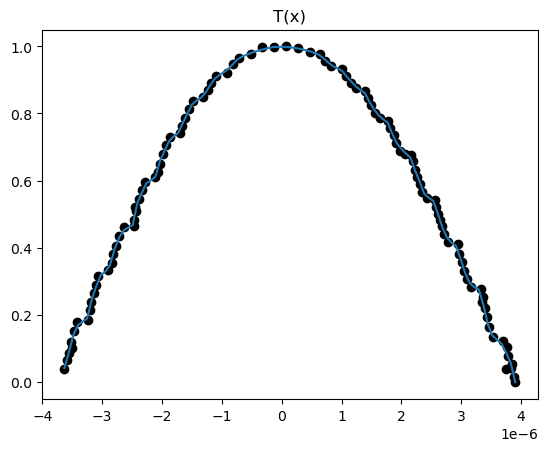

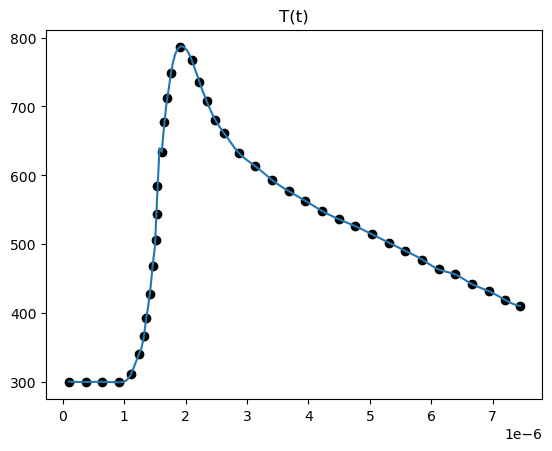

In [17]:
# define boundary conditions

# interpolate normed spatial variance of heating

from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline
y_smooth = savgol_filter(heat_curve_df['normed temperature'],
                            window_length=11,
                            polyorder=3)

heating_xy = make_interp_spline(heat_curve_df['location'], y_smooth, k=1)

import matplotlib.pyplot as plt
x_synthetic = np.linspace(min(heat_curve_df['location']), max(heat_curve_df['location']), 100)
plt.plot(x_synthetic, heating_xy(x_synthetic), zorder =2)
plt.scatter(heat_curve_df['location'], heat_curve_df['normed temperature'], zorder = 1, color ='black')
plt.title('T(x)')
plt.show()

from scipy.interpolate import make_interp_spline
pside_heating_spline_interp = make_interp_spline(df_pside['time'], df_pside['temperature'], k=3)

offset = df_pside['temperature'].iloc[0] - 300
def heating_t(t):
    return float(pside_heating_spline_interp(t)) - offset


# check that spline is reasonable
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.scatter(df_pside['time'], df_pside['temperature']-offset, color = 'black', zorder = 1)

synthetic_x = np.linspace(min(df_pside['time']), max(df_pside['time']), 200)
ax.plot(synthetic_x, [heating_t(x) for x in synthetic_x], zorder = 2)
plt.title('T(t)')
plt.show()
# make time and space varying bc function

def temperature(x,y,t):
    amp = heating_t(t) - 300
    return amp * heating_xy(x) + 300

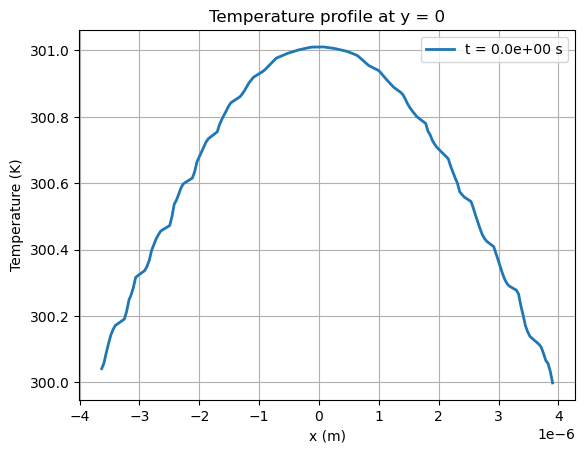

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# pick the time you want to inspect
t_eval = 0e-6          # seconds

# 1-D line of x-locations (reuse x_synthetic if you already have it)
x_line = np.linspace(heat_curve_df['location'].min(),
                     heat_curve_df['location'].max(),
                     200)

# compute T(x, y=0, t=t_eval)
T_line = np.array([temperature(x, 0.0, t_eval) for x in x_line])

# --- plot ---
plt.figure()
plt.plot(x_line, T_line, lw=2, label=f't = {t_eval:.1e} s')
plt.xlabel('x (m)')
plt.ylabel('Temperature (K)')
plt.title('Temperature profile at y = 0')
plt.grid(True)
plt.legend()
plt.show()


In [20]:
# define boundary conditions

bcs=[]

left_bc = RowDirichletBC(spaces.V, 'left', value=ic_temp)
right_bc = RowDirichletBC(spaces.V, 'right', value=ic_temp)
bottom_bc = RowDirichletBC(spaces.V, 'bottom', value=ic_temp)
# leave top bc undefined to have it be adiabatic

# inner spatially and time variable BC

# Center of heating patch along the y‐axis
y_center = 0.0  
    
inner_bc = RowDirichletBC(
    spaces.V,
    'x',
    coord=BX_ir_pside,
    length=max(heat_curve_df['location']) - min(heat_curve_df['location']),
    center=0.0,
    value=temperature
)

obj_bcs = [left_bc, right_bc, bottom_bc, inner_bc]
bcs = [left_bc.bc, right_bc.bc, bottom_bc.bc, inner_bc.bc]


In [21]:
RowDirichletBC.describe_row_bcs(obj_bcs)

Row BC #0: x in [-5.732e-06, -5.732e-06]  y in [-2.000e-05, 1.583e-24]  (n = 201 DOFs)
Row BC #1: x in [5.732e-06, 5.732e-06]  y in [-2.000e-05, -9.525e-24]  (n = 201 DOFs)
Row BC #2: x in [-5.732e-06, 5.732e-06]  y in [-2.000e-05, -2.000e-05]  (n = 135 DOFs)
Row BC #3: x in [-2.470e-06, -2.470e-06]  y in [-3.760e-06, 2.853e-25]  (n = 189 DOFs)


In [22]:
from dolfinx.fem.petsc import assemble_matrix

# timestepping loop

time_stop = 7.0e-6
num_steps = 200
dt = time_stop/num_steps

# init forms

a_form, L_form = spaces.build_variational_forms(rho_cv_fxn, k_fxn, u_n, dt)

# init system matrix
A = assemble_matrix(spaces.a_form, bcs=bcs)
A.assemble()

# init RHS vector
b = fem.petsc.create_vector(L_form)

# init solver

# Create a KSP (Krylov Subspace) solver on the same MPI communicator as A
solver = PETSc.KSP().create(A.getComm())
# Set the operator (matrix) for the solver
solver.setOperators(A)
# Use the PREONLY solver type (no Krylov iterations, direct solve)
pc = solver.getPC()
pc.setType('hypre')

In [31]:
max(df_pside['temperature']) - offset

np.float64(786.5789240000004)

In [23]:
# define outputs folder

import os
outputs_folder = os.path.join(os.getcwd(), 'sim_outputs')

# init io
from io_utilities.xdmf_utils import *

save_folder = os.path.join(outputs_folder, 'new_T')
os.makedirs(save_folder, exist_ok=True)

xdmf = init_xdmf(spaces.mesh, save_folder, 'solution')
uh = fem.Function(spaces.V)
uh.name = 'Temperature (K)'
uh.interpolate(ic_fxn)
xdmf.write_function(uh, 0.0)

In [24]:

# update the bcs to ic state
for x in obj_bcs:
    x.update(0.0)

progress_interval = max(1, num_steps // 10)
for step in range(num_steps):
    t = (step+1)*dt
    inner_bc.update(t)

    # reset and assemble rhs vector
    with b.localForm() as local_b:
        local_b.set(0)
    fem.petsc.assemble_vector(b, L_form)

    # Apply lifting and BCs to RHS
    fem.petsc.apply_lifting(b, [a_form], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bcs)

    # Solve linear system
    solver.solve(b, uh.x.petsc_vec)
    uh.x.scatter_forward()

    # Update previous solution
    u_n.x.array[:] = uh.x.array

    # Write solution at current time
    xdmf.write_function(uh, t)

    # Print progress every 10%
    if (step + 1) % progress_interval == 0 or (step + 1) == num_steps:
        percent = int((step + 1) / num_steps * 100)
        print(f"Simulation progress: {percent}% (step {step + 1}/{num_steps})")

xdmf.close()

Simulation progress: 10% (step 20/200)
Simulation progress: 20% (step 40/200)
Simulation progress: 30% (step 60/200)
Simulation progress: 40% (step 80/200)
Simulation progress: 50% (step 100/200)
Simulation progress: 60% (step 120/200)
Simulation progress: 70% (step 140/200)
Simulation progress: 80% (step 160/200)
Simulation progress: 90% (step 180/200)
Simulation progress: 100% (step 200/200)


In [25]:
from io_utilities.xdmf_extract import *

time, data = extract_point_timeseries_xdmf(os.path.join(save_folder, 'solution.xdmf'), function_name='Temperature (K)', query_points=[(bx_sample, 0), (BX_sample, 0)])
sim_df = pd.DataFrame({'time': time,
                       'pside': data[0],
                       'oside': data[1]})

sim_df['normed pside'] = (sim_df['pside'] - sim_df['pside'].iloc[0]) / (max(sim_df['pside']) - min(sim_df['pside']))
sim_df['normed oside'] = (sim_df['oside'] - sim_df['oside'].iloc[0]) / (max(sim_df['pside']) - min(sim_df['pside']))

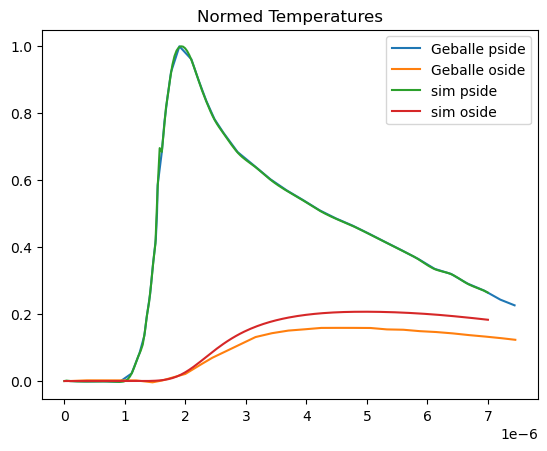

In [26]:
# absolute temp

fig, ax = plt.subplots()

ax.set_title('Normed Temperatures')
ax.plot(df_pside['time'], df_pside['normed temperature'], label = 'Geballe pside')
ax.plot(df_oside['time'], df_oside['normed temperature'], label = 'Geballe oside')

ax.plot(sim_df['time'], sim_df['normed pside'], label = 'sim pside')
ax.plot(sim_df['time'], sim_df['normed oside'], label = 'sim oside')

ax.legend()

In [27]:
max(sim_df['normed oside']) - max(df_oside['normed temperature'])

0.04809590193145016

In [28]:
query_points = []
xmin = bx_ir_pside - 2e-6
xmax = BX_ir_oside + 2e-6
samples = 200

for x in np.linspace(xmin, xmax, samples):
    query_points.append((x, 0.0))

time, data = extract_point_timeseries_xdmf(os.path.join(save_folder, 'solution.xdmf'), function_name='Temperature (K)', query_points=query_points)
locations = np.arange(data.shape[0])

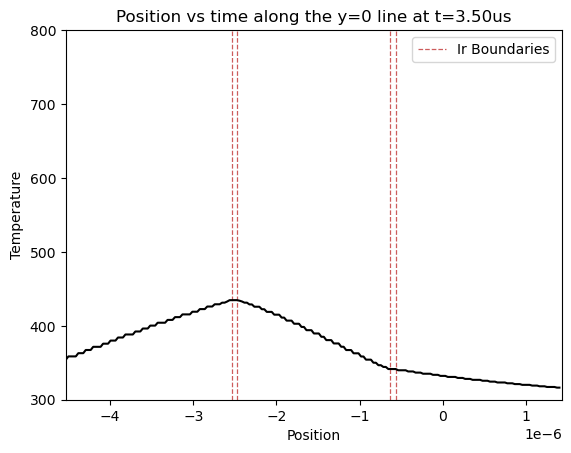

In [29]:
sim_df = pd.DataFrame(data, index=locations.astype(int), columns=time)

fig, ax = plt.subplots()

t0 = 100
location_series = (locations/samples) * (xmax - xmin) + xmin
ymin = 300
ymax = 800

ax.plot(location_series, sim_df.iloc[:, t0], zorder = 3, color = 'black')
ax.vlines([BX_sample, bx_sample, bx_ir_pside, BX_ir_oside], ymin=ymin, ymax=ymax, ls = '--', label = 'Ir Boundaries', color = 'indianred', zorder = 2, lw=0.9)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_xlabel('Position')
ax.set_ylabel('Temperature')
ax.set_title(f'Position vs time along the y=0 line at t={t0*dt*10**6:.2f}us')
ax.legend()

plt.show()